In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def calculate_metrics(test_labels, test_predictions):
    cm = confusion_matrix(test_labels, test_predictions)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, specificity, sensitivity, f1

def downsample_block(x, filters):
    x = layers.Conv1D(filters // 2, 1, strides=1, padding='same')(x)  # Use filters // 2
    x = advanced_pool_operator(x)
    return x

def advanced_nodal_operator(x, filters, kernel_size=5, activation='relu'):
    # Branch 1: Convolution with dilation
    y1 = layers.Conv1D(filters // 2, kernel_size, dilation_rate=2, padding='same')(x)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.Activation(activation)(y1)

    # Branch 2: Depthwise separable convolution
    y2 = layers.SeparableConv1D(filters // 2, kernel_size, padding='same')(x)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.Activation(activation)(y2)

    # Concatenate outputs
    y = layers.Concatenate()([y1, y2])
    return y

def advanced_pool_operator(x, pool_size=2, strides=1):
    # Mixed Pooling: Average and Max
    y1 = layers.AveragePooling1D(pool_size, strides, padding='same')(x)
    y2 = layers.MaxPooling1D(pool_size, strides, padding='same')(x)
    y = layers.Concatenate()([y1, y2])
    return y

def squeeze_and_excitation_block(x, ratio=16):
    num_channels = x.shape[-1]
    squeeze = layers.GlobalAveragePooling1D()(x)
    excitation = layers.Dense(num_channels // ratio, activation='relu')(squeeze)
    excitation = layers.Dense(num_channels, activation='sigmoid')(excitation)
    excitation = layers.Reshape((1, num_channels))(excitation)
    scale = layers.Multiply()([x, excitation])
    return scale

def residual_block_SERA_AwGOP(x, filters, kernel_size=5, downsample=False):
    y = advanced_nodal_operator(x, filters, kernel_size)
    y = advanced_nodal_operator(y, filters, kernel_size)

    if downsample:
        x = downsample_block(x, filters)  # Downsample x only once

    y = squeeze_and_excitation_block(y)  # Apply SE block to the nodal output

    # Advanced GOP: Attention-based weighting
    attention_weights = layers.Dense(1, activation='sigmoid')(x)
    gop_out = layers.Multiply()([attention_weights, y])  # Weighted output
    gop_out = layers.Add()([gop_out, x])  # Residual connection
    gop_out = layers.Activation('relu')(gop_out)
    return gop_out

def create_SERA_AwGOP(input_shape, num_classes, filters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters[0], 5, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    for f in filters[1:]: 
        x = residual_block_SERA_AwGOP(x, f, downsample=True)  
        x = residual_block_SERA_AwGOP(x, f)  
        x = residual_block_SERA_AwGOP(x, f)
        x = residual_block_SERA_AwGOP(x, f)

    x = layers.GlobalAveragePooling1D()(x)
    if(num_classes==2):
        outputs = layers.Dense(1, activation='sigmoid')(x)
    else:
        outputs = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

training_data = np.load("/Users/soumilhooda/Desktop/ECG-Chapman/Grad-CAM/3-class_0vs1_train_data.npy")
training_labels = np.load("/Users/soumilhooda/Desktop/ECG-Chapman/Grad-CAM/3-class_0vs1_train_labels.npy")
test_data = np.load("/Users/soumilhooda/Desktop/ECG-Chapman/Grad-CAM/3-class_0vs1_test_data.npy")
test_labels = np.load("/Users/soumilhooda/Desktop/ECG-Chapman/Grad-CAM/3-class_0vs1_test_labels.npy")
input_shape = (5000, 12)
num_classes = 2
filters = [32, 64, 128]

model = create_SERA_AwGOP(input_shape, num_classes, filters)
if num_classes == 2:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Model Summary:")
model.summary()
history = model.fit(training_data, training_labels, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
test_predictions = model.predict(test_data)
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

test_predictions_binary = (test_predictions > 0.5).astype(int)
# Save confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)
print("Confusion Matrix:")
print(cm)
np.save(f'confusion_matrix.npy', cm)

# Calculate additional scores
precision, recall, specificity, sensitivity, f1 = calculate_metrics(test_labels, test_predictions_binary)
print(f'Precision: {precision}, Recall: {recall}, Specificity: {specificity}, Sensitivity: {sensitivity}, F1 Score: {f1}')

model.save(f'SERA_AwGOP_model', save_format='tf')

2024-04-14 02:03:05.547681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 02:03:12.570214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2500, 32)     1952        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1250, 32)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1250, 32)     5152        ['max_pooling1d[0][0]']          
                                                                               

INFO:tensorflow:Assets written to: SERA_AwGOP_model/assets


INFO:tensorflow:Assets written to: SERA_AwGOP_model/assets


In [2]:
# import matplotlib.pyplot as plt

# # Define the layer names
# layer_names = ['conv1d_1', 'conv1d_3', 'conv1d_4', 'conv1d_5', 'conv1d_11', 'conv1d_12', 'conv1d_13', 'conv1d_18']

# # Loop through each layer
# for layer_name in layer_names:
#     # Set up the figure for the current layer
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Access the layer by name
#     layer = model.get_layer(layer_name)

#     # Get the weights of the layer
#     weights, biases = layer.get_weights()

#     # Plot the first and last filters as images
#     axs[0].imshow(weights[:, :, 0], cmap='magma')
#     axs[0].set_title(f"{layer_name} - First Filter")
#     axs[0].set_xlabel('Input Data Index')
#     axs[0].set_ylabel('Filter Index')
#     axs[0].axis('off')
#     axs[1].imshow(weights[:, :, -1], cmap='magma')
#     axs[1].set_title(f"{layer_name} - Last Filter")
#     axs[1].set_xlabel('Input Data Index')
#     axs[1].set_ylabel('Filter Index')
#     axs[1].axis('off')

#     # Adjust layout and display the plot for the current layer
#     plt.tight_layout()
#     plt.show()

# layer_name = 'dense_24'  # Change this to the desired dense layer name
# layer = model.get_layer(layer_name)
# weights, biases = layer.get_weights()

# # Reshape the weights matrix
# weights_reshaped = weights.reshape((-1, weights.shape[-1]))

# # Plot the weights of the dense layer
# plt.figure(figsize=(6, 3))
# plt.bar(range(weights_reshaped.shape[0]), weights_reshaped[:, 0])  # Plot the weights of the first neuron
# plt.xlabel('Input Connection Index')
# plt.ylabel('Weight Value')
# plt.title('Weights of Dense Layer')
# plt.show()  

# import seaborn as sns

# # Set the layer name
# layer_name = 'dense_1'

# # Get the layer
# layer = model.get_layer(layer_name)

# # Get the weights
# weights, biases = layer.get_weights()

# # Reshape the weights matrix
# weights_reshaped = weights.reshape((-1, weights.shape[-1]))

# # Plot the heatmap of the weights
# plt.figure(figsize=(10, 6))
# sns.heatmap(weights_reshaped, cmap='viridis', cbar=True)
# plt.xlabel('Neuron Index')
# plt.ylabel('Input Connection Index')
# plt.title('Weights of Dense Layer')
# plt.show()

# # Set the layer name
# layer_name = 'dense_24'

# # Get the layer
# layer = model.get_layer(layer_name)

# # Get the weights
# weights, biases = layer.get_weights()

# # Reshape the weights matrix
# weights_reshaped = weights.reshape((-1, weights.shape[-1]))

# # Plot the heatmap of the weights
# plt.figure(figsize=(10, 6))
# sns.heatmap(weights_reshaped, cmap='viridis', cbar=True)
# plt.xlabel('Neuron Index')
# plt.ylabel('Input Connection Index')
# plt.title('Weights of Dense Layer')
# plt.show()


1/1 [==============================] - 0s 43ms/step


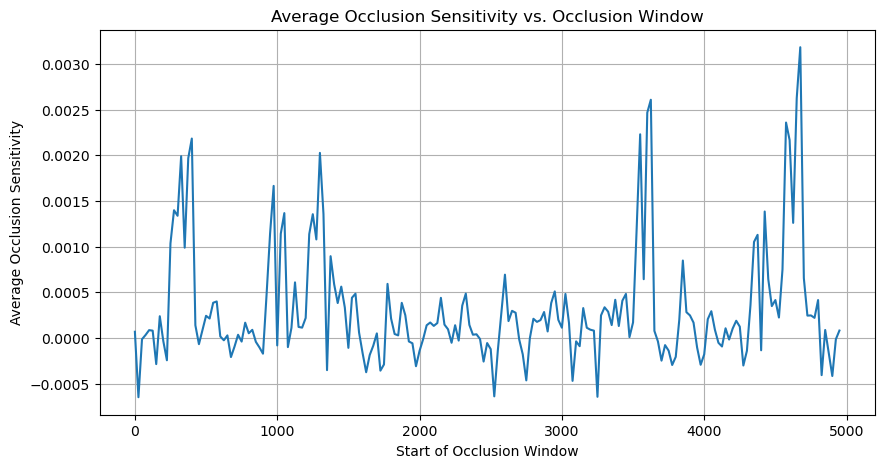

In [3]:
def occlusion_sensitivity(model, input_data, target_class, window_size, stride):
    # Get the original prediction
    original_prediction = model.predict(input_data)[0, 0]

    # Initialize an empty list to store the occlusion sensitivity values
    occlusion_sensitivity_values = []

    # Iterate through the input data with the specified stride
    for i in range(0, input_data.shape[1] - window_size + 1, stride):
        # Create a copy of the input data
        input_data_copy = input_data.copy()
        # Mask out a small window of the input data
        input_data_copy[:, i:i+window_size, :] = 0  # Replace the window with zeros
        # Compute the prediction after occluding the window
        occluded_prediction = model.predict(input_data_copy)[0, 0]
        # Compute the occlusion sensitivity value for this window
        occlusion_sensitivity_values.append(original_prediction - occluded_prediction)

    return np.array(occlusion_sensitivity_values)

def occlusion_sensitivity_multiple_samples(model, input_data, target_class, window_size, stride, num_samples):
    occlusion_sensitivity_values_all = []
    
    # Select a subset of samples (ensure enough samples of the target class)
    target_indices = np.where(test_labels == target_class)[0]
    if len(target_indices) < num_samples:
        num_samples = len(target_indices)
    selected_indices = np.random.choice(target_indices, num_samples, replace=False)

    for sample_index in selected_indices:
        sample_data = np.expand_dims(input_data[sample_index], axis=0)
        # Calculate occlusion sensitivity for the individual sample
        occlusion_sensitivity_values = occlusion_sensitivity(model, sample_data, target_class, window_size, stride)
        occlusion_sensitivity_values_all.append(occlusion_sensitivity_values)

    # Calculate the average occlusion sensitivity across samples
    average_occlusion_sensitivity = np.mean(occlusion_sensitivity_values_all, axis=0)
    
    return average_occlusion_sensitivity

# Example usage:
num_samples_to_analyze = 10  # Choose the number of samples
average_occlusion_sensitivity = occlusion_sensitivity_multiple_samples(
    model, test_data, target_class=1, window_size=50, stride=25, num_samples=num_samples_to_analyze
)

# Plot the average occlusion sensitivity
plt.figure(figsize=(10, 5))
plt.plot(range(0, test_data.shape[1] - 50 + 1, 25), average_occlusion_sensitivity)
plt.xlabel('Start of Occlusion Window')
plt.ylabel('Average Occlusion Sensitivity')
plt.title('Average Occlusion Sensitivity vs. Occlusion Window')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 43ms/step


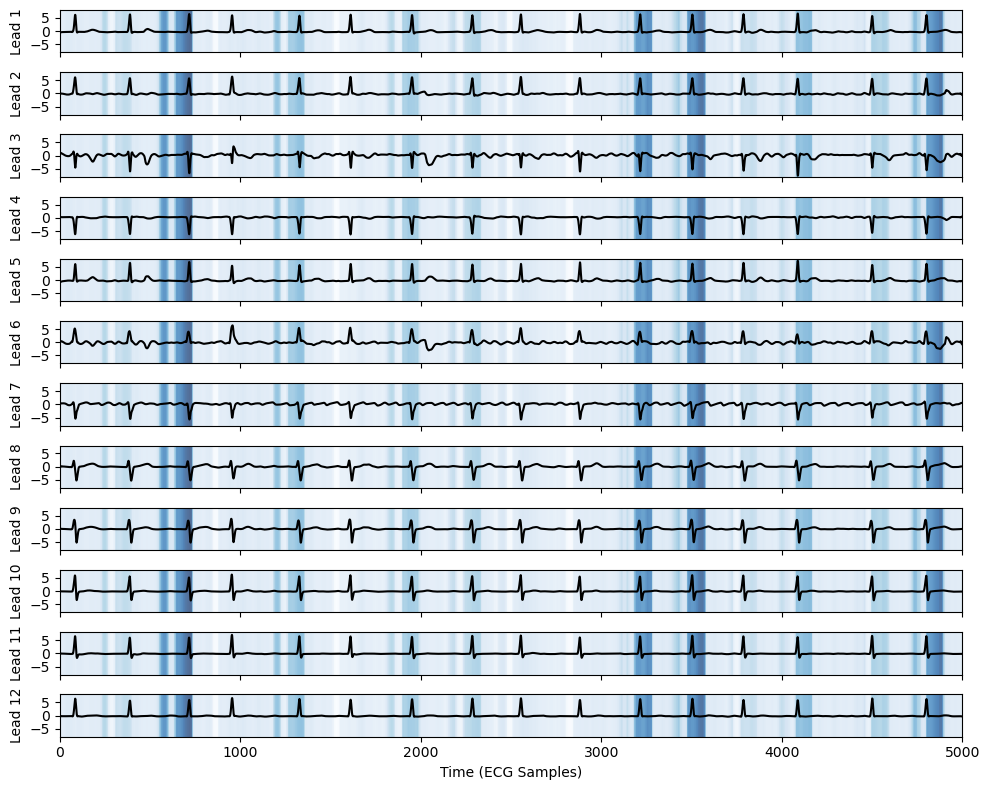

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

def visualize_occlusion_heatmap(model, sample_data, target_class, window_size, stride, num_ecg_samples=None):
    num_leads = sample_data.shape[2]  # Get the number of leads (12 in your case)

    # Calculate occlusion sensitivity for the target class
    occlusion_sensitivity_values = occlusion_sensitivity(model, sample_data, target_class, window_size, stride)

    # # Normalize occlusion sensitivity values to [0, 1]
    # occlusion_sensitivity_values = (occlusion_sensitivity_values - np.min(occlusion_sensitivity_values)) / (np.max(occlusion_sensitivity_values) - np.min(occlusion_sensitivity_values))

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit and transform the occlusion sensitivity values using StandardScaler
    occlusion_sensitivity_values = scaler.fit_transform(occlusion_sensitivity_values.reshape(-1, 1)).flatten()

    # Limit ECG samples if num_ecg_samples is provided
    if num_ecg_samples is not None:
        sample_data = sample_data[:, :num_ecg_samples, :]

    # Create figure and subplots for each lead
    fig, axes = plt.subplots(num_leads, 1, figsize=(10, 8), sharex=True)

    # Set colormap based on target class
    cmap = 'Reds' if target_class == 0 else 'Blues'

    # Plot each lead with occlusion sensitivity heatmap
    for i in range(num_leads):
        axes[i].plot(sample_data[0, :, i], color='black')  # Plot ECG in black
        im = axes[i].imshow(occlusion_sensitivity_values[np.newaxis, :], cmap=cmap, aspect='auto', alpha=0.7, extent=[0, sample_data.shape[1], -8, 8])  # Adjust extent for overlay
        axes[i].set_ylabel(f'Lead {i+1}')
        axes[i].set_ylim(-8, 8)  # Set custom y-axis limits

    # # Add colorbar outside the plot
    # cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label=f'Occlusion Sensitivity (Class {target_class})', shrink=0.8)  # Adjust shrink as needed

    # Set x-axis label
    axes[-1].set_xlabel('Time (ECG Samples)')

    plt.tight_layout()
    plt.show()

# Example Usage:
num_samples_to_visualize = 1  # Number of samples to visualize
class_to_visualize = 1  # Choose the class (0 or 1)
num_ecg_samples_to_plot = 5000  # Plot only the first 3000 ECG samples (adjust as needed)

# Select indices of samples belonging to the chosen class
target_indices = np.where(training_labels == class_to_visualize)[0]

# Randomly select a subset of samples if needed
if len(target_indices) > num_samples_to_visualize:
    selected_indices = np.random.choice(target_indices, num_samples_to_visualize, replace=False)
else:
    selected_indices = target_indices

# Visualize occlusion heatmaps for the selected samples
for sample_index in selected_indices:
    sample_data = training_data[sample_index][np.newaxis, ...]
    visualize_occlusion_heatmap(model, sample_data, target_class=class_to_visualize, window_size=25, stride=5, num_ecg_samples=num_ecg_samples_to_plot)


1/1 [==============================] - 0s 43ms/step


/var/folders/q1/d82dt4ns3kd7h9yk5cv3ysfr0000gn/T/ipykernel_3193/3736603193.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


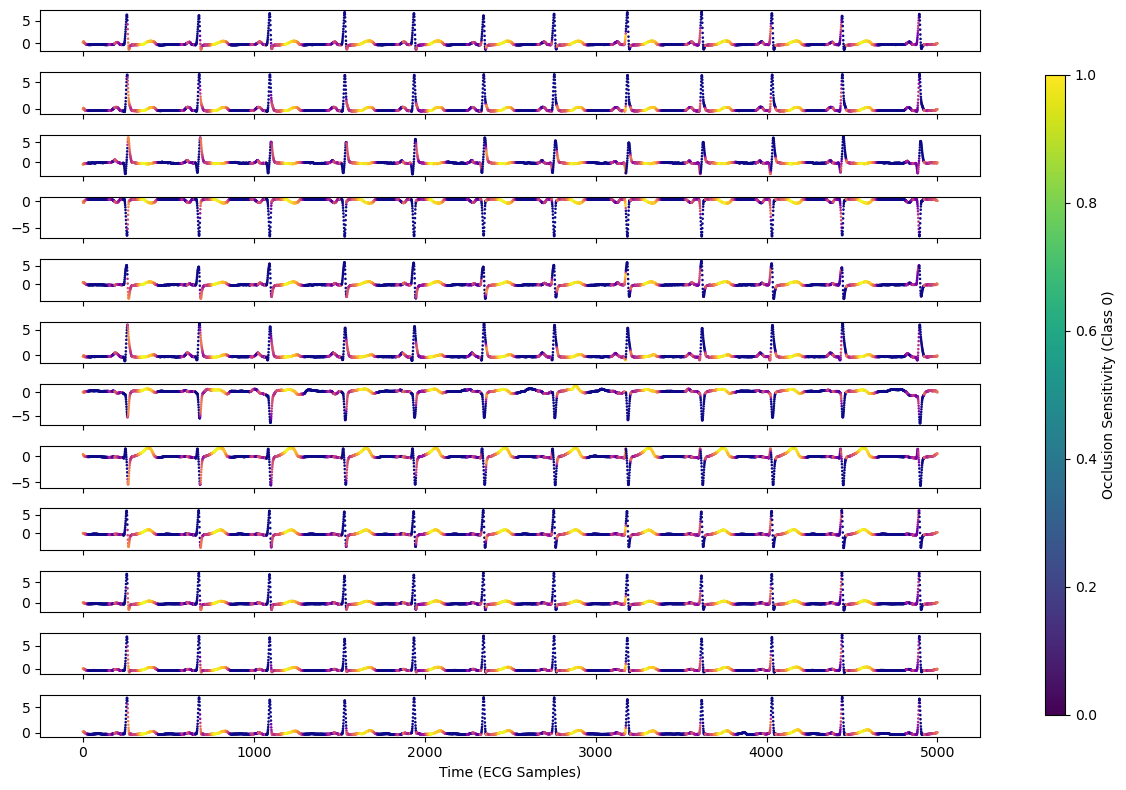

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

def visualize_occlusion_heatmap(model, sample_data, target_class, window_size, stride, num_ecg_samples=None):
    num_leads = sample_data.shape[2]  # Get the number of leads (12 in your case)

    # Calculate occlusion sensitivity for the target class
    occlusion_sensitivity_values = occlusion_sensitivity(model, sample_data, target_class, window_size, stride)

    # Standardize occlusion sensitivity values
    scaler = StandardScaler()
    occlusion_sensitivity_values = scaler.fit_transform(occlusion_sensitivity_values.reshape(-1, 1)).flatten()

    # Limit ECG samples if num_ecg_samples is provided
    if num_ecg_samples is not None:
        sample_data = sample_data[:, :num_ecg_samples, :]

    # Create figure and subplots for each lead
    fig, axes = plt.subplots(num_leads, 1, figsize=(10, 8), sharex=True)

    # Set colormap based on target class
    cmap = 'plasma' if target_class == 0 else 'plasma'

# Plot each lead with occlusion sensitivity heatmap
    for i in range(num_leads):
        # Create color-mapped ECG line
        ecg_colors = plt.get_cmap(cmap)(occlusion_sensitivity_values)

        # Interpolate occlusion sensitivity values to match ECG signal length
        interp_occlusion_sensitivity = np.interp(np.linspace(0, 1, sample_data.shape[1]), 
                                                 np.linspace(0, 1, len(occlusion_sensitivity_values)), 
                                                 occlusion_sensitivity_values)
        ecg_colors = plt.get_cmap(cmap)(interp_occlusion_sensitivity)

        im = axes[i].scatter(range(sample_data.shape[1]), sample_data[0, :, i], c=ecg_colors, marker='.', s=3)  # Adjust marker size as needed

    # Add colorbar to the right of the plots
    cax = fig.add_axes([1.05, 0.1, 0.02, 0.8])  # Adjust position and size as needed
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', label=f'Occlusion Sensitivity (Class {target_class})')


    # Set x-axis label
    axes[-1].set_xlabel('Time (ECG Samples)')

    plt.tight_layout()
    plt.show()


# Example Usage:
num_samples_to_visualize = 1  # Number of samples to visualize
class_to_visualize = 0  # Choose the class (0 or 1)
num_ecg_samples_to_plot = 5000  # Plot only the first 3000 ECG samples (adjust as needed)

# Select indices of samples belonging to the chosen class
target_indices = np.where(training_labels == class_to_visualize)[0]

# Randomly select a subset of samples if needed
if len(target_indices) > num_samples_to_visualize:
    selected_indices = np.random.choice(target_indices, num_samples_to_visualize, replace=False)
else:
    selected_indices = target_indices

# Visualize occlusion heatmaps for the selected samples
for sample_index in selected_indices:
    sample_data = training_data[sample_index][np.newaxis, ...]
    visualize_occlusion_heatmap(model, sample_data, target_class=class_to_visualize, window_size=25, stride=5, num_ecg_samples=num_ecg_samples_to_plot)

1/1 [==============================] - 0s 64ms/step


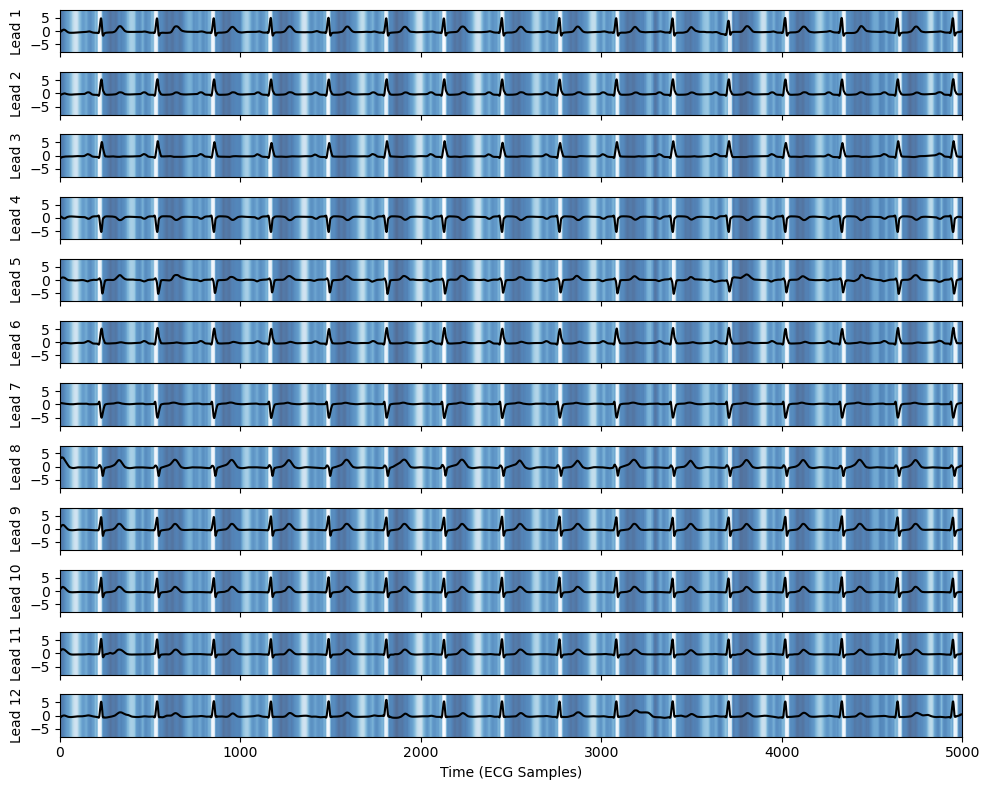

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_occlusion_heatmap(model, sample_data, target_class, window_size, stride, num_ecg_samples=None):
    num_leads = sample_data.shape[2]  # Get the number of leads (12 in your case)

    # Calculate occlusion sensitivity for the target class
    occlusion_sensitivity_values = occlusion_sensitivity(model, sample_data, target_class, window_size, stride)

    # Normalize occlusion sensitivity values to [0, 1]
    occlusion_sensitivity_values = (occlusion_sensitivity_values - np.min(occlusion_sensitivity_values)) / (np.max(occlusion_sensitivity_values) - np.min(occlusion_sensitivity_values))

    # Limit ECG samples if num_ecg_samples is provided
    if num_ecg_samples is not None:
        sample_data = sample_data[:, :num_ecg_samples, :]

    # Create figure and subplots for each lead
    fig, axes = plt.subplots(num_leads, 1, figsize=(10, 8), sharex=True)

    # Set colormap based on target class
    cmap = 'Blues' if target_class == 0 else 'Blues'

    # Plot each lead with occlusion sensitivity heatmap
    for i in range(num_leads):
        axes[i].plot(sample_data[0, :, i], color='black')  # Plot ECG in black
        im = axes[i].imshow(occlusion_sensitivity_values[np.newaxis, :], cmap=cmap, aspect='auto', alpha=0.7, extent=[0, sample_data.shape[1], -8, 8])  # Adjust extent for overlay
        axes[i].set_ylabel(f'Lead {i+1}')
        axes[i].set_ylim(-8, 8)  # Set custom y-axis limits

    # # Add colorbar outside the plot
    # cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label=f'Occlusion Sensitivity (Class {target_class})', shrink=0.8)  # Adjust shrink as needed

    # Set x-axis label
    axes[-1].set_xlabel('Time (ECG Samples)')

    plt.tight_layout()
    plt.show()

# Example Usage:
num_samples_to_visualize = 1  # Number of samples to visualize
class_to_visualize = 0  # Choose the class (0 or 1)
num_ecg_samples_to_plot = 5000  # Plot only the first 3000 ECG samples (adjust as needed)

# Select indices of samples belonging to the chosen class
target_indices = np.where(training_labels == class_to_visualize)[0]

# Randomly select a subset of samples if needed
if len(target_indices) > num_samples_to_visualize:
    selected_indices = np.random.choice(target_indices, num_samples_to_visualize, replace=False)
else:
    selected_indices = target_indices

# Visualize occlusion heatmaps for the selected samples
for sample_index in selected_indices:
    sample_data = training_data[sample_index][np.newaxis, ...]
    visualize_occlusion_heatmap(model, sample_data, target_class=class_to_visualize, window_size=25, stride=5, num_ecg_samples=num_ecg_samples_to_plot)


1/1 [==============================] - 0s 48ms/step


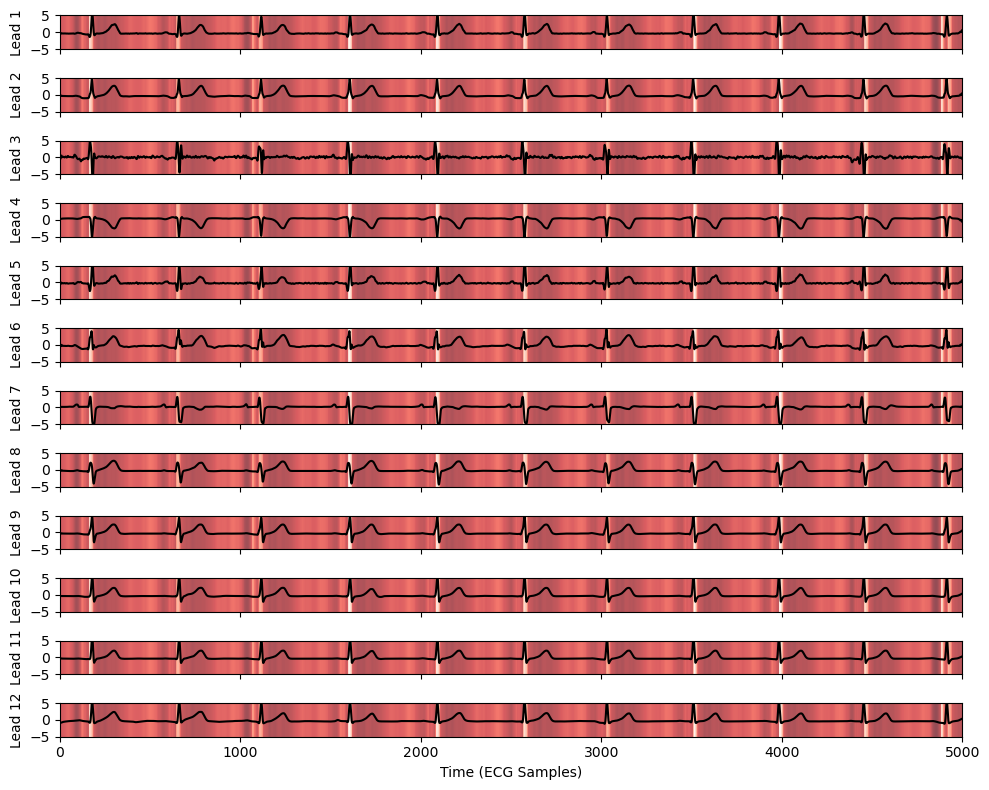

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_data(data_path):
    try:
        df = pd.read_csv(data_path, header=None)
        data = df.to_numpy().astype(np.float32)

        # Scale the electrode data separately for each electrode
        scaler = StandardScaler()
        scaled_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            scaled_data[:, i] = scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten()

        scaled_data = scaled_data.reshape(1, 5000, 12)
        return scaled_data
    except Exception as e:
        print("Error loading data:", e)
        return None

def visualize_occlusion_heatmap(model, sample_data, target_class, window_size, stride, num_ecg_samples=None):
    num_leads = sample_data.shape[2]  # Get the number of leads (12 in your case)

    # # Normalize ECG data between -1 and 1
    # sample_data = 2 * (sample_data - np.min(sample_data)) / (np.max(sample_data) - np.min(sample_data)) - 1

    # Calculate occlusion sensitivity for the target class
    occlusion_sensitivity_values = occlusion_sensitivity(model, sample_data, target_class, window_size, stride)

    # Normalize occlusion sensitivity values to [0, 1]
    occlusion_sensitivity_values = (occlusion_sensitivity_values - np.min(occlusion_sensitivity_values)) / (np.max(occlusion_sensitivity_values) - np.min(occlusion_sensitivity_values))

    # Limit ECG samples if num_ecg_samples is provided
    if num_ecg_samples is not None:
        sample_data = sample_data[:, :num_ecg_samples, :]

    # Create figure and subplots for each lead
    fig, axes = plt.subplots(num_leads, 1, figsize=(10, 8), sharex=True)

    # Set colormap based on target class
    cmap = 'Reds' if target_class == 0 else 'Blues'

    # Plot each lead with occlusion sensitivity heatmap
    for i in range(num_leads):
        axes[i].plot(sample_data[0, :, i], color='black')  # Plot ECG in black
        im = axes[i].imshow(occlusion_sensitivity_values[np.newaxis, :], cmap=cmap, aspect='auto', alpha=0.7, extent=[0, sample_data.shape[1], -5, 5])  # Adjust extent for overlay
        axes[i].set_ylabel(f'Lead {i+1}')
        # axes[i].set_ylim(-8, 8)  # Set custom y-axis limits

    # # Add colorbar outside the plot
    # cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label=f'Occlusion Sensitivity (Class {target_class})', shrink=0.8)  # Adjust shrink as needed

    # Set x-axis label
    axes[-1].set_xlabel('Time (ECG Samples)')

    plt.tight_layout()
    plt.show()

# Example Usage:
num_samples_to_visualize = 1  # Number of samples to visualize
class_to_visualize = 0  # Choose the class (0 or 1)
num_ecg_samples_to_plot = 5000  # Plot only the first 3000 ECG samples (adjust as needed)

# Path to the CSV file
csv_file_path = "/Users/soumilhooda/Desktop/ECG-Chapman/V2/ONN_Models/ECGDataDenoised/MUSE_20180209_172046_21000.csv"

# Preprocess the data
sample_data = preprocess_data(csv_file_path)

# Visualize occlusion heatmaps for the selected samples
for sample_index in selected_indices:
    visualize_occlusion_heatmap(model, sample_data, target_class=class_to_visualize, window_size=25, stride=5, num_ecg_samples=num_ecg_samples_to_plot)


1/1 [==============================] - 0s 55ms/step


/var/folders/q1/d82dt4ns3kd7h9yk5cv3ysfr0000gn/T/ipykernel_3193/3159022705.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


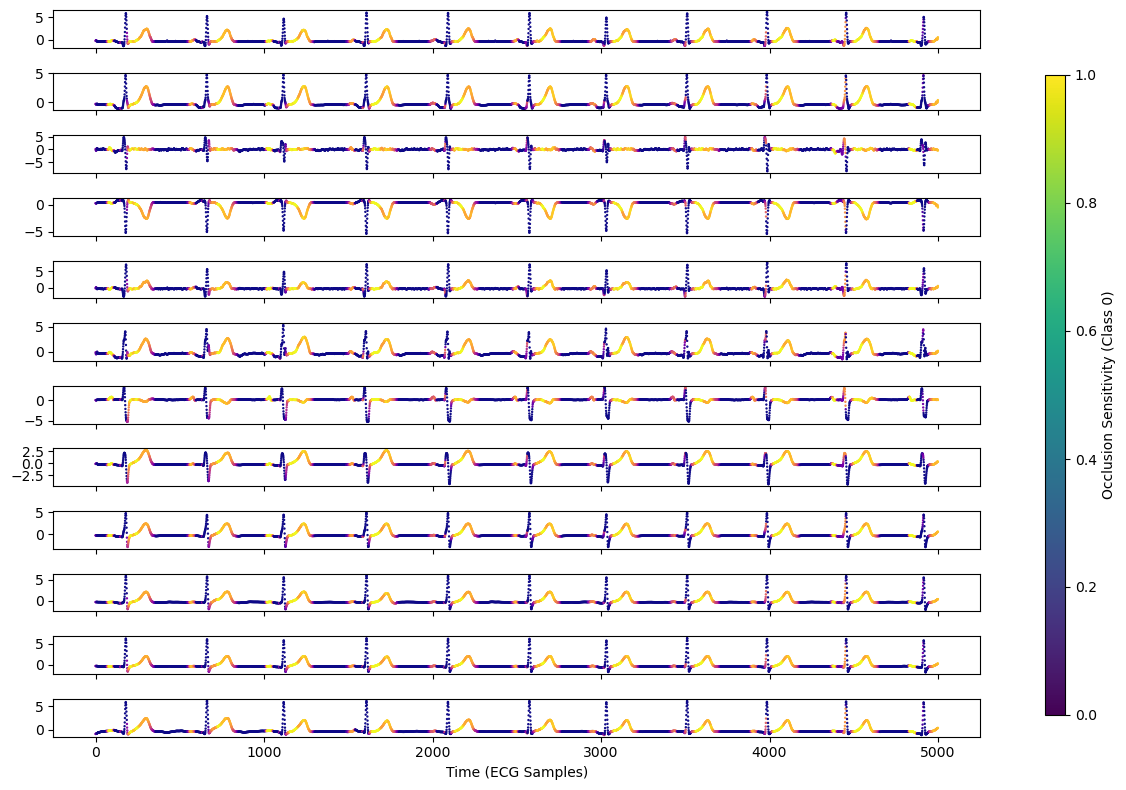

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(data_path):
    try:
        df = pd.read_csv(data_path, header=None)
        data = df.to_numpy().astype(np.float32)

        # Scale the electrode data separately for each electrode
        scaler = StandardScaler()
        scaled_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            scaled_data[:, i] = scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten()

        scaled_data = scaled_data.reshape(1, 5000, 12)
        return scaled_data
    except Exception as e:
        print("Error loading data:", e)
        return None

def visualize_occlusion_heatmap(model, sample_data, target_class, window_size, stride, num_ecg_samples=None):
    num_leads = sample_data.shape[2]  # Get the number of leads (12 in your case)

    # # Normalize ECG data between -1 and 1
    # sample_data = 2 * (sample_data - np.min(sample_data)) / (np.max(sample_data) - np.min(sample_data)) - 1

    # Calculate occlusion sensitivity for the target class
    occlusion_sensitivity_values = occlusion_sensitivity(model, sample_data, target_class, window_size, stride)

    # Standardize occlusion sensitivity values
    scaler = StandardScaler()
    occlusion_sensitivity_values = scaler.fit_transform(occlusion_sensitivity_values.reshape(-1, 1)).flatten()

    # Limit ECG samples if num_ecg_samples is provided
    if num_ecg_samples is not None:
        sample_data = sample_data[:, :num_ecg_samples, :]

    # Create figure and subplots for each lead
    fig, axes = plt.subplots(num_leads, 1, figsize=(10, 8), sharex=True)

    # Set colormap based on target class
    cmap = 'plasma' if target_class == 0 else 'plasma'

# Plot each lead with occlusion sensitivity heatmap
    for i in range(num_leads):
        # Create color-mapped ECG line
        ecg_colors = plt.get_cmap(cmap)(occlusion_sensitivity_values)

        # Interpolate occlusion sensitivity values to match ECG signal length
        interp_occlusion_sensitivity = np.interp(np.linspace(0, 1, sample_data.shape[1]), 
                                                 np.linspace(0, 1, len(occlusion_sensitivity_values)), 
                                                 occlusion_sensitivity_values)
        ecg_colors = plt.get_cmap(cmap)(interp_occlusion_sensitivity)

        im = axes[i].scatter(range(sample_data.shape[1]), sample_data[0, :, i], c=ecg_colors, marker='.', s=2)  # Adjust marker size as needed

    # Add colorbar to the right of the plots
    cax = fig.add_axes([1.05, 0.1, 0.02, 0.8])  # Adjust position and size as needed
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', label=f'Occlusion Sensitivity (Class {target_class})')


    # Set x-axis label
    axes[-1].set_xlabel('Time (ECG Samples)')

    plt.tight_layout()
    plt.show()


# Example Usage:
num_samples_to_visualize = 1  # Number of samples to visualize
class_to_visualize = 0  # Choose the class (0 or 1)
num_ecg_samples_to_plot = 5000  # Plot only the first 3000 ECG samples (adjust as needed)

# Path to the CSV file
csv_file_path = "/Users/soumilhooda/Desktop/ECG-Chapman/V2/ONN_Models/ECGDataDenoised/MUSE_20180209_172046_21000.csv"

# Preprocess the data
sample_data = preprocess_data(csv_file_path)

# Visualize occlusion heatmaps for the selected samples
for sample_index in selected_indices:
    visualize_occlusion_heatmap(model, sample_data, target_class=class_to_visualize, window_size=25, stride=5, num_ecg_samples=num_ecg_samples_to_plot)
